# Introduction à pytorch

In [61]:
import torch
import torch.nn.functional as F
from torch.autograd import grad
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
from typing import Callable
from warnings import warn

## I) Les tenseurs

L'outil central de la librairie et la classe torch.Tensor qui permet de faire des calculs vectorizés et être indéxé à la manière d'une array numpy.
C'est un bloc contigue de mémoire qui contient des données typées, et est découpé en plusieurs dimensions. En plus du type de données, on peut définir si le tenseur requiert la propagation du gradient, et l'appareil sur lequel les données sont stockées et où les opérations seront effectuées ("cpu" ou "cuda:i").

In [62]:
t = torch.tensor([[1, 5], [3, 2]], dtype=torch.float32, requires_grad=False, device="cpu")  # la fonction "torch.tensor" permet de créer un tenseur de manière analogue à "np.array"
print(repr(t))

tensor([[1., 5.],
        [3., 2.]])


In [63]:
2*t - t**0.5 + 2  # Les opérations usuelles en numpy sont disponibles

tensor([[3.0000, 9.7639],
        [6.2679, 4.5858]])

In [64]:
(t.shape, t.dtype, t.requires_grad, t.device)  # les attributs usuels des array numpy sont nommées de manière identiques

(torch.Size([2, 2]), torch.float32, False, device(type='cpu'))

In [65]:
t[1, 1], t[:, 1], t[..., 0], t[0], t[:, :1]  # Les syntaxes d'indentation sont identiques à celles de numpy

(tensor(2.),
 tensor([5., 2.]),
 tensor([1., 3.]),
 tensor([1., 5.]),
 tensor([[1.],
         [3.]]))

Toutes les opérations usuelles de la librairie numpy existent dans pytorch (ou presque). Si le tenseur est sur un GPU, le calcul sera effectué de manière parallélisée sur GPU, ce qui peut très largement accélérer la vitesse d'execution pour des tenseurs de grande taille.

In [66]:
t.min(), t.mean(dim=1), t.max(), t.std(dim=0)  # les méthodes usuelles des array numpy sont nommées de manière identiques. Le kwargs "ax" est renommé "dim".

(tensor(1.), tensor([3.0000, 2.5000]), tensor(5.), tensor([1.4142, 2.1213]))

In [67]:
t @ -t  # Les opérateur propres aux array numpy sont aussi implémentés. Ici équivalent à "torch.matmul(t, -t)".

tensor([[-16., -15.],
        [ -9., -19.]])

In [68]:
torch.exp(-t**2 + 2)  # les fonctions mathématiques courantes sont disponibles dans le namespace "torch"

tensor([[2.7183e+00, 1.0262e-10],
        [9.1188e-04, 1.3534e-01]])

In [69]:
F.elu(-t)  # Les fonctions liées à des opérations propres aux réseaux de neurones (loss, convolutions, activation, ...) se trouvent dans le namespace "torch.nn.functional"

tensor([[-0.6321, -0.9933],
        [-0.9502, -0.8647]])

In [70]:
torch.linalg.inv(t)  # Les fonctions d'algèbre linéaires de numpy sont implémentées dans le namespace "torch.linalg". Ici une opération d'inversion matricielle (dont on peut obtenir le gradient !)

tensor([[-0.1538,  0.3846],
        [ 0.2308, -0.0769]])

In [71]:
torch.rand((1,)), torch.randint(0, 3, (1,)), torch.normal(0., 1., (1,))  # Les fonctions de génération de nombres aléatoires ne sont pas (contrairement à numpy) dans le namespace torch.random !

(tensor([0.4073]), tensor([2]), tensor([-0.0641]))

Tout comme pour les arrays numpy, on peut réorganiser la taille des dimensions (sans que la taille totale du tenseur ne change) ou l'ordre des dimensions

In [72]:
t = torch.arange(2*3*3, dtype=torch.long)
print(repr(t))
t = t.reshape(3, 2, 3)
print(repr(t))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])


In [73]:
t.transpose(1, 2)  # inverse l'ordre des dimensions 1 et 2

tensor([[[ 0,  3],
         [ 1,  4],
         [ 2,  5]],

        [[ 6,  9],
         [ 7, 10],
         [ 8, 11]],

        [[12, 15],
         [13, 16],
         [14, 17]]])

In [74]:
t.permute(1, 0, 2)  # permute l'ordre de toutes les dimensions dans l'ordre spécifié

tensor([[[ 0,  1,  2],
         [ 6,  7,  8],
         [12, 13, 14]],

        [[ 3,  4,  5],
         [ 9, 10, 11],
         [15, 16, 17]]])

In [75]:
t.unsqueeze(0).shape  # la méthode "unsqueeze" permet de créer des dimensions vide

torch.Size([1, 3, 2, 3])

In [76]:
t.unsqueeze(0).squeeze(0).shape  # la méthode "squeeze" à l'inverse permet de retirer une dimension vide

torch.Size([3, 2, 3])

## II) création du graph de calcul

Lorsqu'un tenseur requiert la propagation du gradient, le graphe de calcul est créé dynamiquement, de manière transparente pour l'utilisateur, lorsqu'on effectue des opérations, le résultat renvoyé est un nouveau tenseur lié au précédent par une branche du graphe deu calcul. Pour cette raison, il ne faut jamais modifier manuellement le contenu des tenseurs à travers lesquels on compte propager le gradient.

In [77]:
t = torch.arange(4, dtype=torch.float32, requires_grad=True)
print(repr(t))

tensor([0., 1., 2., 3.], requires_grad=True)


In [78]:
r = torch.sum(t**2)  # notez la présence de la "grad_fn" (gradient function) qui a donné lieu au nouveau tenseur.
print(repr(r))

tensor(14., grad_fn=<SumBackward0>)


In [79]:
r.backward()  # la méthode "backward" permet de propager le gradient dans tous le graph
print(repr(t.grad))  # on retrouve la solution analytique de la dérivée de la somme des carrés (y = 2*x), évaluées en [0, 1, 2, 3].

tensor([0., 2., 4., 6.])


In [80]:
# Une fois le gradient propagé, les résultats intermédiaires du graph de calcul sont supprimés pour libérer de la mémoire.
# On ne peut pas appeler backward une deuxième fois
try:
    r.backward()
except Exception as e:
    print(str(e))

Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


In [81]:
# On remarque alors que pytorch "accumule" les gradients au lieux d'écrire la nouvelle valuer par dessus l'ancienne.
r = torch.sum(t**2)
r.backward()
print(repr(t.grad))


tensor([ 0.,  4.,  8., 12.])


In [82]:
# Utiliser un contexte "torch.no_grad()" permet de ne pas construire le graph de calcul, et donc d'économiser la mémoire, et d'accélérer le calcul
t = torch.arange(4, dtype=torch.float32, requires_grad=True)
with torch.no_grad():
    r = torch.sum(t**2)
print(r.requires_grad)

False


## III) Les Modules pytorch

Dans pytorch une brique de modèle (une couche d'un modèle feed forward, ...) comme un modèle entier dérivent de la classe Module.
Les classes filles doivent implémenter la fonction "forward" qui correspond à la passe avant de la couche/du modèle (aka: l'opération effectuée)

In [83]:
lin = torch.nn.Linear(2, 3)  # certaines couches courrament utilisées sont déjà implémentées

In [84]:
help(lin)  # La couche linéaire (y = x@A.T + b) attend en entrée un tenseur de shape (n_observations, features_in) et renvoit un tenseur de shape (n_observations, features_out)

Help on Linear in module torch.nn.modules.linear object:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(*, H_{in})` where :math:`*` means any number of
 |        dimensions including none and :math:`H_{in} = \text{in\_features}`.
 |      - Output: :math:`(*, H_{out})` where all but the last dimension
 |        are the same shape as the input and :math:`H_{out} = \text{out\_features}`.
 |  
 |  Attributes:
 |      weight: the learnable weights of the module of shape
 |          :math:`

In [85]:
r = lin(torch.rand(10, 2))  # on peut appliquer l'opération correspondante en utilisant l'opérateur __call__
print(repr(r))

tensor([[ 0.2887, -0.9111,  0.0200],
        [ 0.0291, -1.0574, -0.1099],
        [ 0.1471, -0.4161,  0.4967],
        [ 0.3199, -0.8433,  0.0835],
        [ 0.3041, -0.8418,  0.0855],
        [-0.0541, -0.7252,  0.2097],
        [-0.0252, -0.9114,  0.0312],
        [ 0.0389, -1.2528, -0.2963],
        [ 0.0052, -1.1013, -0.1508],
        [-0.0205, -1.1146, -0.1625]], grad_fn=<AddmmBackward0>)


In [86]:
list(lin.parameters())  # on peut obtenir un itérable des paramètres d'un module ave cla méthode "parameters"

[Parameter containing:
 tensor([[-0.4047,  0.1841],
         [-0.5728, -0.6449],
         [-0.5309, -0.6210]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2012, -0.2627,  0.6409], requires_grad=True)]

In [87]:
# On peut définir ses propres modules en dérivant la classe torch.nn.Module
class MyModule(torch.nn.Module):

    def __init__(self, in_features, out_features, activation):
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.activation = activation
    
    def forward(self, X):
        X = self.linear(X)
        X = self.activation(X)
        return X


In [88]:
module = MyModule(2, 3, torch.relu)

In [89]:
# les module ont une représentation sous forme de string qui détaille leur contenu récursivement
module

MyModule(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [90]:
# de la même manière que pour la couche "Linear", on peut appliquer notre couche "MyModule"
module(torch.rand(10, 2))

tensor([[0.0000, 0.7473, 0.0000],
        [0.0000, 0.9001, 0.0000],
        [0.0000, 0.7601, 0.0000],
        [0.0000, 0.8522, 0.0000],
        [0.0000, 0.8739, 0.0000],
        [0.0000, 0.7199, 0.0000],
        [0.0000, 0.7979, 0.0000],
        [0.0000, 0.8664, 0.0000],
        [0.0000, 0.8639, 0.0000],
        [0.0000, 0.8773, 0.0000]], grad_fn=<ReluBackward0>)

In [91]:
list(module.children())  # On peut récupérer un itérable sur les sous modules avec la méthode "children"

[Linear(in_features=2, out_features=3, bias=True)]

In [92]:
list(module.parameters())  # La méthode "parameter" renvoit aussi les groupes de paramètres des sous modules

[Parameter containing:
 tensor([[-0.4066,  0.3551],
         [ 0.1848,  0.1451],
         [ 0.3324, -0.5491]], requires_grad=True),
 Parameter containing:
 tensor([-0.5230,  0.6584, -0.5060], requires_grad=True)]

In [93]:
# Certains Modules ne doivent pas avoir le même comportement lors de l'entraînement et de l'évaluation.
# Un flag permet de déterminer si le module est en mode entraînement ou évaluation
dropout = torch.nn.Dropout(p=0.5)
dropout.training

True

In [94]:
# on peut passer un module (et ses sous modules recursivement) en mode entraînement avec la méthode "train"
dropout.train()
dropout(torch.rand(3, 3))

tensor([[0.0043, 0.0000, 1.6588],
        [0.4361, 0.0000, 0.0000],
        [0.3332, 0.0000, 0.0000]])

In [95]:
# on peut passer un module (et ses sous modules recursivement) en mode entraînement avec la méthode "eval"
dropout.eval()
dropout(torch.rand(3, 3))

tensor([[0.0178, 0.5963, 0.9538],
        [0.8426, 0.3605, 0.1383],
        [0.9357, 0.5460, 0.3921]])

## IV) Les algorithmes d'optimization

In [96]:
# On peut définir des paramètres personnalisés pour nos modules
p = torch.nn.parameter.Parameter(torch.zeros(1))

In [97]:
# les algorithmes d'optimization sont disponibles dans le namespace torch.optim
# ils prennent généralement en paramètre la liste de sparamètres du modèle, et le lerning rate
optimizer = torch.optim.Adam([p], lr=1.0E-3)

In [98]:
# propagation du gradient
loss = p**2 + 2*p - 1
loss.backward()
print(p.grad)

tensor([2.])


In [99]:
# appeler la méthode "step" permet de faire un pas de l'algorithme d'optimizationµ
optimizer.step()
print(repr(p))

Parameter containing:
tensor([-0.0010], requires_grad=True)


In [100]:
# pour remettre à zéro le graident il faut appeler la méthode "zero_grad" avant chaque back propagation
optimizer.zero_grad()
print(p.grad)

tensor([0.])


## V) Le checkpointing et la sauvegarde de modèle

In [101]:
# On peut obtenir un dictionnaire d'état d'un Module avec la méthode "state_dict"
module.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.4066,  0.3551],
                      [ 0.1848,  0.1451],
                      [ 0.3324, -0.5491]])),
             ('linear.bias', tensor([-0.5230,  0.6584, -0.5060]))])

In [102]:
# pour créer des checkpoint, il faut faire une copie profonde de l'état pour ne pas garder une référence sur les tenseurs, mais une copie
checkpoint = deepcopy(module.state_dict())

In [103]:
# on peut charger un état sauvegardé en mémoire avec la méthode "load_state_dict"
module.load_state_dict(checkpoint)

<All keys matched successfully>

In [104]:
# pour sauvegarder un objet python sur le disk/charger un bojet depuis le disk, on peut utiliser les fonctions torch.save et torch.load
help(torch.save)

Help on function save in module torch.serialization:

save(obj, f: Union[str, os.PathLike, BinaryIO, IO[bytes]], pickle_module=<module 'pickle' from 'c:\\Users\\Benoit\\miniconda3\\lib\\pickle.py'>, pickle_protocol=2, _use_new_zipfile_serialization=True) -> None
    save(obj, f, pickle_module=pickle, pickle_protocol=DEFAULT_PROTOCOL, _use_new_zipfile_serialization=True)
    
    Saves an object to a disk file.
    
    See also: :ref:`saving-loading-tensors`
    
    Args:
        obj: saved object
        f: a file-like object (has to implement write and flush) or a string or
           os.PathLike object containing a file name
        pickle_module: module used for pickling metadata and objects
        pickle_protocol: can be specified to override the default protocol
    
    .. note::
        A common PyTorch convention is to save tensors using .pt file extension.
    
    .. note::
        PyTorch preserves storage sharing across serialization. See
        :ref:`preserve-storage-s

In [105]:
help(torch.load)

Help on function load in module torch.serialization:

load(f, map_location=None, pickle_module=<module 'pickle' from 'c:\\Users\\Benoit\\miniconda3\\lib\\pickle.py'>, **pickle_load_args)
    load(f, map_location=None, pickle_module=pickle, **pickle_load_args)
    
    Loads an object saved with :func:`torch.save` from a file.
    
    :func:`torch.load` uses Python's unpickling facilities but treats storages,
    which underlie tensors, specially. They are first deserialized on the
    CPU and are then moved to the device they were saved from. If this fails
    (e.g. because the run time system doesn't have certain devices), an exception
    is raised. However, storages can be dynamically remapped to an alternative
    set of devices using the :attr:`map_location` argument.
    
    If :attr:`map_location` is a callable, it will be called once for each serialized
    storage with two arguments: storage and location. The storage argument
    will be the initial deserialization of the st

## Exercice I

Definir un Module correspondant à une couche cachée d'un modèle feed forward

In [106]:
class Layer(torch.nn.Module):
    """
    Un objet 'Layer' est une couche cachée d'un réseau feed forward
    """

    def __init__(self, in_features: int, out_features: int, activation: Callable, dropout: float, with_batch_norm: bool):
        """
        Parameters
        ----------
        in_features : int
            number of features in input tensors
        out_features : int
            number of features in output
        activation : Callable
            activation function applied after linear projection and batch normalization
        dropout : float
            dropout probability for gidden layers
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.with_batch_norm = with_batch_norm
        self.batch_norm = torch.nn.BatchNorm1d(out_features)
        self.activation = activation
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, H_in)
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        X = self.linear(X)
        if self.with_batch_norm:
            X = self.batch_norm(X)
        X = self.activation(X)
        X = self.dropout(X)
        return X

## Exercice II

Définir la classe FeedForwardRegressor

Compléter la fonction "train_loop" pour qu'elle entraîne le modèle sur les données générées

In [107]:
def y(x: torch.Tensor) -> torch.Tensor:
    return x**2 + torch.normal(0., 0.1, x.shape)

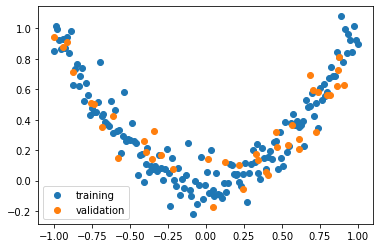

In [108]:
x_train = torch.linspace(-1., 1., 160).unsqueeze(1)
y_train = y(x_train)
x_val = torch.rand((40, 1)) * 2 - 1
y_val = y(x_val)
plt.scatter(x_train.reshape(-1).tolist(), y_train.reshape(-1).tolist(), label="training")
plt.scatter(x_val.reshape(-1).tolist(), y_val.reshape(-1).tolist(), label="validation")
plt.legend()

In [109]:
class FeedForwardRegressor(torch.nn.Module):
    """
    Un objet 'FeedForwardRegressor' est un modèle feed forward pour la régression
    """

    def __init__(self, in_features: int, hidden_features: list[int], activation: Callable = F.relu, dropout: float = 0., with_batch_norm: bool = True):
        super().__init__()
        self.hidden_layers = torch.nn.ModuleList()
        for out_features in hidden_features:
            self.hidden_layers.append(Layer(in_features, out_features, activation, dropout, with_batch_norm))
            in_features = out_features
        self.output_projection = torch.nn.Linear(out_features, 1)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, H_in)
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        for layer in self.hidden_layers:
            X = layer(X)
        return self.output_projection(X)

In [110]:
def train_loop(model: torch.nn.Module, optimizer: torch.optim.Optimizer, train_data: tuple[torch.Tensor], val_data: tuple[torch.Tensor], loss_function: Callable, n_steps: int = 100, patience: int = 10, keep_best: bool = True):
    """
    performs the training for a given number of iterations
    """
    x_train, y_train = train_data
    x_val, y_val = val_data
    best_metric = float("inf")
    best_step = 0
    checkpoint = deepcopy(model.state_dict())
    try:
        for step in range(n_steps):
            # setting the gradient to zero to avoid gradient accumulation
            optimizer.zero_grad()
            # training
            model.train()
            loss = loss_function(model(x_train), y_train)
            loss.backward()
            # validation
            model.eval()
            with torch.no_grad():
                metric = loss_function(model(x_val), y_val).item()
            if metric < best_metric:
                best_metric = metric
                best_step = step
                if keep_best:
                    checkpoint = deepcopy(model.state_dict())
            elif step - best_step == patience:
                print("early stopping")
                break
            # printing progress
            print(f"Step {step}: loss = {loss.item():.3g}, metric = {metric:.3g}", flush=True)
            # step of the optimizer
            optimizer.step()
    except KeyboardInterrupt:
        print("interupted by user")
    if keep_best:
        model.load_state_dict(checkpoint)

In [111]:
# Entraînement du modèle
ffr = FeedForwardRegressor(1, [30, 30])
optimizer = torch.optim.Adam(ffr.parameters(), lr=1.0E-3)
train_loop(ffr, optimizer, (x_train, y_train), (x_val, y_val), F.mse_loss, n_steps=200, patience=100)

Step 0: loss = 0.148, metric = 0.0978
Step 1: loss = 0.112, metric = 0.0928
Step 2: loss = 0.0825, metric = 0.0877
Step 3: loss = 0.0605, metric = 0.0844
Step 4: loss = 0.0444, metric = 0.0829
Step 5: loss = 0.0327, metric = 0.0812
Step 6: loss = 0.0245, metric = 0.079
Step 7: loss = 0.0192, metric = 0.0766
Step 8: loss = 0.016, metric = 0.0739
Step 9: loss = 0.0147, metric = 0.0718
Step 10: loss = 0.0147, metric = 0.0699
Step 11: loss = 0.0151, metric = 0.0676
Step 12: loss = 0.0154, metric = 0.0654
Step 13: loss = 0.0155, metric = 0.0634
Step 14: loss = 0.0154, metric = 0.0617
Step 15: loss = 0.0149, metric = 0.0604
Step 16: loss = 0.0141, metric = 0.0594
Step 17: loss = 0.0131, metric = 0.0586
Step 18: loss = 0.0122, metric = 0.0582
Step 19: loss = 0.0115, metric = 0.0576
Step 20: loss = 0.011, metric = 0.0566
Step 21: loss = 0.0108, metric = 0.0555
Step 22: loss = 0.0106, metric = 0.0541
Step 23: loss = 0.0104, metric = 0.0523
Step 24: loss = 0.0103, metric = 0.0503
Step 25: loss =

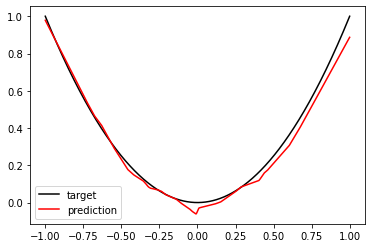

In [112]:
x_test = torch.linspace(-1, 1, 1000)
y_target = x_test**2
y_pred = ffr(x_test.unsqueeze(-1)).squeeze(-1)
plt.plot(x_test.tolist(), y_target.tolist(), color="k", label="target")
plt.plot(x_test.tolist(), y_pred.tolist(), color="r", label="prediction")
plt.legend()

## Exercice III

Définir et entraîner un modèle de classification binaire

In [113]:
def y(x: torch.Tensor) -> torch.Tensor:
    """
    returns the binary classification of the given (x1, x2) points

    Parameters
    ----------
    x : torch.Tensor
        tensor of shape (n, 2) of floats in [-1, 1]

    Returns
    -------
    torch.Tensor
        tensor of shape (n, 1) of type long, of values in {0, 1}
    """
    L = 0.8
    return (((x[:, 0] + x[:, 1]) % L) > L/2).float().unsqueeze(-1)


def generate_data(n: int) -> tuple[torch.Tensor]:
    """
    generate an (x, y) tuple of tensors of n random observations
    """
    x = torch.rand(n, 2) * 2 - 1
    y_ = y(x)
    return x, torch.where(torch.rand(n, 1) < 0.05, 1-y_, y_)

In [114]:
x_train, y_train = generate_data(800)
x_val, y_val = generate_data(200)

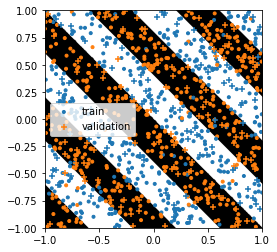

In [115]:
image = y(torch.stack(torch.meshgrid([torch.linspace(-1., 1., 500)]*2, indexing="ij"), dim=-1).reshape(-1, 2)).reshape(500, 500)
plt.imshow(image, extent=(-1, 1, -1, 1), origin="lower", cmap="Greys", vmin=0, vmax=1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=[f"C{c.item()}" for c in y_train.int()], marker=".", label="train")
plt.scatter(x_val[:, 0], x_val[:, 1], c=[f"C{c.item()}" for c in y_val.int()], marker="+", label="validation")
plt.legend()

In [116]:
class FeedForwardClassifier(torch.nn.Module):
    """
    Un objet 'FeedForwardRegressor' est un modèle feed forward pour la classification binaire
    """

    def __init__(self, in_features: int, hidden_layers: list[int], activation: Callable = F.relu, dropout: float = 0., with_batch_norm: bool = True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for out_features in hidden_layers:
            self.layers.append(Layer(in_features, out_features, activation, dropout, with_batch_norm))
            in_features = out_features
        self.output_projection = torch.nn.Linear(out_features, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            X = layer(X)
        return torch.sigmoid(self.output_projection(X))

In [117]:
ffc = FeedForwardClassifier(2, [30, 30, 30, 30])
optimizer = torch.optim.Adam(ffc.parameters(), lr=1.0E-3)
train_loop(ffc, optimizer, (x_train, y_train), (x_val, y_val), F.binary_cross_entropy, n_steps=1000, patience=100)

Step 0: loss = 0.718, metric = 0.688
Step 1: loss = 0.704, metric = 0.689
Step 2: loss = 0.693, metric = 0.689
Step 3: loss = 0.685, metric = 0.689
Step 4: loss = 0.678, metric = 0.69
Step 5: loss = 0.672, metric = 0.69
Step 6: loss = 0.667, metric = 0.691
Step 7: loss = 0.662, metric = 0.691
Step 8: loss = 0.657, metric = 0.691
Step 9: loss = 0.652, metric = 0.692
Step 10: loss = 0.648, metric = 0.692
Step 11: loss = 0.644, metric = 0.692
Step 12: loss = 0.64, metric = 0.693
Step 13: loss = 0.636, metric = 0.693
Step 14: loss = 0.631, metric = 0.693
Step 15: loss = 0.627, metric = 0.693
Step 16: loss = 0.623, metric = 0.694
Step 17: loss = 0.619, metric = 0.693
Step 18: loss = 0.614, metric = 0.693
Step 19: loss = 0.61, metric = 0.692
Step 20: loss = 0.605, metric = 0.691
Step 21: loss = 0.6, metric = 0.69
Step 22: loss = 0.595, metric = 0.689
Step 23: loss = 0.59, metric = 0.687
Step 24: loss = 0.585, metric = 0.685
Step 25: loss = 0.58, metric = 0.683
Step 26: loss = 0.575, metric =

In [118]:
with torch.no_grad():
    image = ffc(torch.stack(torch.meshgrid([torch.linspace(-1., 1., 500)]*2, indexing="ij"), dim=-1).reshape(-1, 2)).reshape(500, 500)

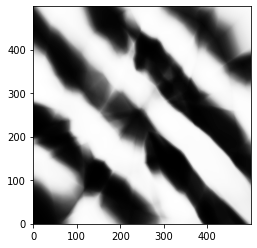

In [119]:
plt.imshow(image.numpy(), origin="lower", cmap="Greys")

## Exercice IV

Définir et entraîner sur le dataset parcoursup-2021 un modèle qui prédit avec intervale de confiance le taux d'admission de chaque formation



In [122]:
df = pd.read_csv("../datasets/parcoursup-2021/train.csv")
df_train = df.sample(frac=0.8)
df_val = df.drop(df_train.index)
df_test = pd.read_csv("../datasets/parcoursup-2021//test.csv")
df_eval = pd.read_csv("../datasets/parcoursup-2021/eval_public.csv")
df_eval = pd.read_csv("../datasets/parcoursup-2021/eval.csv")

all_inputs = ['type_contrat', 'formation_selective',
              'concour', 'nombre_candidats', 'taux_femmes',
              'taux_boursiers', 'taux_meme_academie', 'taux_meme_etablissement',
              'taux_bac_technologique', 'taux_bac_pro', 'taux_mention_assez_bien',
              'taux_mention_bien', 'taux_mention_tres_bien',
              'taux_mention_tres_bien_felicitations']
target = 'taux_admission'

In [123]:
class GaussianRegressor(torch.nn.Module):
    """
    Un régresseur gaussien doit renvoyer un tuple de tenseurs (mu, sigma)
    avec mu la moyenne prédite pour chaque observation,
    et sigma l'écart type de l'erreur pour chaque observation.
    """

    def __init__(self, in_features: int, hidden_features: list[int], activation: Callable = F.relu, dropout: float = 0., with_batch_norm: bool = True):
        super().__init__()
        self.hidden_layers = torch.nn.ModuleList()
        for out_features in hidden_features:
            self.hidden_layers.append(Layer(in_features, out_features, activation, dropout, with_batch_norm=with_batch_norm))
            in_features = out_features
        self.output_projection = torch.nn.Linear(in_features, 2)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, 14)
        
        Returns
        -------
        tuple of torch.Tensor :
            returns a tuple of (mu, sigma) tensors of shape (N,)
        """
        for layer in self.hidden_layers:
            X = layer(X)
        X = self.output_projection(X)
        mu, sigma = X[..., 0], X[..., 1]
        return torch.sigmoid(mu), torch.exp(sigma)

In [124]:
def dataframe_to_x(df: pd.DataFrame, inputs: list[str]) -> torch.Tensor:
    """
    converts a dataframe to a tensor of inputs 'x'

    Parameters
    ----------
    df : pd.DataFrame
        data to convert to input tensor
    inputs : list of str
        list of columns to use (in order)
    
    Returns
    -------
    torch.Tensor :
        tensor of floats of shape (N, C)
    """
    df = df[inputs].copy()
    if "nombre_candidats" in df.columns:
        df["nombre_candidats"] = df["nombre_candidats"]/1413
    if "type_contrat" in df.columns:
        df["type_contrat"] = [0 if tc.startswith("Public") else 1 for tc in df["type_contrat"]]
    return torch.tensor(df.astype(float).to_numpy(), dtype=torch.float32)


def dataframe_to_y(df: pd.DataFrame) -> torch.Tensor:
    """
    converts a dataframe to a tensor of target 'y'

    Parameters
    ----------
    df : pd.DataFrame
        data to convert to target tensor

    Returns
    -------
    torch.Tensor :
        tensor of floats of shape (N, C)
    """
    return torch.tensor(df['taux_admission'].astype(float).to_numpy(), dtype=torch.float32)


def predict(model: torch.nn.Module, df: pd.DataFrame, inputs: list[str]) -> torch.Tensor:
    """
    performs a prediction of the model in evaluation mode
    and returns the (mu, sigma) tuple
    """
    x = dataframe_to_x(df, inputs=inputs)
    model.eval()
    with torch.no_grad():
        mu, sigma = model(x)
    return pd.DataFrame.from_dict({"mu": mu.tolist(), "sigma": sigma.tolist()})


def mean_negative_log_likelyhood(y_pred: tuple[torch.Tensor], y_target: torch.Tensor) -> torch.Tensor:
    """
    returns the mean negative log likelyhood of the model, to be used as a loss
    """
    mu, sigma = y_pred
    if (sigma <= 0).any():
        warn("All values of sigma are expected to be strictly positives but found some negative or null")
    log_likelyhood = -0.5*(((y_target-mu)/sigma)**2) - torch.log(sigma * (2*torch.pi)**0.5)
    return torch.mean(-log_likelyhood)


def visualize(model: torch.nn.Module, df_test: pd.DataFrame, inputs: list[str]):
    """
    Plots the performance of the model
    """
    y = dataframe_to_y(df_test)
    res = predict(model, df_test, inputs)
    plt.axline((0., 0.), slope=1, color="k", zorder=0)
    h = plt.scatter(res.mu, y, c=res.sigma, cmap="inferno", s=10, zorder=1)
    plt.colorbar(h)
    plt.xlabel("target")
    plt.ylabel("predicted")

In [125]:
inputs =  all_inputs
train = (dataframe_to_x(df_train, inputs), dataframe_to_y(df_train))
val = (dataframe_to_x(df_val, inputs), dataframe_to_y(df_val))
gr = GaussianRegressor(len(inputs), [30, 30], activation=F.leaky_relu, dropout=0.)
optimizer = torch.optim.Adam(gr.parameters(), lr=1.0E-3)
train_loop(gr, optimizer, train, val, mean_negative_log_likelyhood, n_steps=1000, patience=100)

Step 0: loss = 1.16, metric = 1.03
Step 1: loss = 1.14, metric = 1.02
Step 2: loss = 1.12, metric = 1.02
Step 3: loss = 1.1, metric = 1.01
Step 4: loss = 1.08, metric = 1.01
Step 5: loss = 1.06, metric = 1
Step 6: loss = 1.04, metric = 0.998
Step 7: loss = 1.02, metric = 0.992
Step 8: loss = 1, metric = 0.987
Step 9: loss = 0.983, metric = 0.981
Step 10: loss = 0.963, metric = 0.975
Step 11: loss = 0.944, metric = 0.968
Step 12: loss = 0.925, metric = 0.961
Step 13: loss = 0.906, metric = 0.954
Step 14: loss = 0.887, metric = 0.945
Step 15: loss = 0.868, metric = 0.937
Step 16: loss = 0.85, metric = 0.927
Step 17: loss = 0.831, metric = 0.918
Step 18: loss = 0.813, metric = 0.907
Step 19: loss = 0.795, metric = 0.896
Step 20: loss = 0.777, metric = 0.884
Step 21: loss = 0.759, metric = 0.871
Step 22: loss = 0.741, metric = 0.857
Step 23: loss = 0.724, metric = 0.843
Step 24: loss = 0.707, metric = 0.828
Step 25: loss = 0.69, metric = 0.812
Step 26: loss = 0.673, metric = 0.795
Step 27:

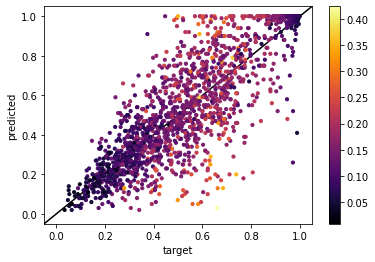

In [127]:
visualize(gr, df_test, inputs)